In [1]:
import numpy as np 

from yt_idv.coordinate_utilities import (
    SphericalMixedCoordBBox,
    cartesian_bboxes,
    cartesian_bboxes_edges, # from edges 
    cartesian_to_spherical,
    spherical_to_cartesian,
)
import matplotlib.pyplot as plt 

yt conventions for spherical coordinates:

* r : radius
* theta: colatitude, 0 to pi
* phi: azimuth (longitudinal angle), 0 to 2pi

Set up a single element -- in order to create visualizations easily, going to make an element that spans the equator over a very narrow range. this allows an almost 2d element, and we can plot in 2d

In [2]:

r0 = np.array([0.8]) 
r1 = np.array([0.9])

# a small variation about np.pi/2 will be almost 2d, nice for visualization here
theta0 = np.array([np.pi/2-.01])
theta1 = np.array([np.pi/2+.01])

phi0 = np.array([0.4])
phi1 = np.array([0.6])

bbox_handler = SphericalMixedCoordBBox()

le, re = cartesian_bboxes_edges(bbox_handler, r0, theta0, phi0, r1, theta1, phi1)


set some ray cases, select which to use

In [3]:
ray_cases = [
    {'origin': [.6, .3, .0], 'camera_position': [.9, .45, .0]},
    {'origin': [.65, .48, .0], 'camera_position': [.9, .45, .0]},   
    {'origin': [.65, .48, .0], 'camera_position': [.85, .325, .0]},   
    {'origin': [.4, .3, .0], 'camera_position': [.9, .45, .0]},
]
i_ray = 3

In [4]:
# create a ray, get x, y values for plotting
ray_origin = np.array(ray_cases[i_ray]['origin'])
camera_position = np.array(ray_cases[i_ray]['camera_position'])

ray_dir = (camera_position - ray_origin) / np.linalg.norm(camera_position - ray_origin)
dist = np.linalg.norm(camera_position - ray_origin)

t = np.linspace(0, dist, 50)

x = ray_origin[0] + t * ray_dir[0]
y = ray_origin[1] + t * ray_dir[1]
z = ray_origin[2] + t * ray_dir[2]

In [5]:
# x-y projection of element -- sort of, since it spans the equator, wont be too bad 

phi_range = np.linspace(phi0, phi1, 25)

x_el_in = r0 * np.cos(phi_range)
y_el_in = r0 * np.sin(phi_range)

x_el_out = r1 * np.cos(phi_range)
y_el_out = r1 * np.sin(phi_range)

r_range = np.linspace(r0, r1, 25)
x_el_phi0 = r_range * np.cos(phi0)
y_el_phi0 = r_range * np.sin(phi0)
x_el_phi1 = r_range * np.cos(phi1)
y_el_phi1 = r_range * np.sin(phi1)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

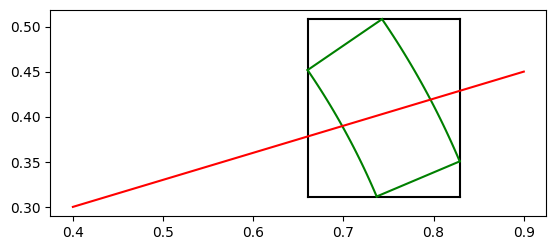

In [6]:
def plot_elements():
    fig, axs = plt.subplots(1)
    # cartesian bounding box 
    axs.plot([le[0], re[0]], [le[1], le[1]],'k')
    axs.plot([le[0], re[0]], [re[1], re[1]],'k')
    axs.plot([le[0], le[0]], [le[1], re[1]],'k')
    axs.plot([re[0], re[0]], [le[1], re[1]],'k')
    
    # the element 
    axs.plot(x_el_in,y_el_in,'g')
    axs.plot(x_el_out,y_el_out,'g')
    axs.plot(x_el_phi0,y_el_phi0,'g')
    axs.plot(x_el_phi1,y_el_phi1,'g')
    
    # a ray 
    axs.plot(x, y,'r')
    axs.set_aspect('equal')
    return fig, axs

plot_elements()    

# slab test

e.g., https://tavianator.com/2022/ray_box_boundary.html

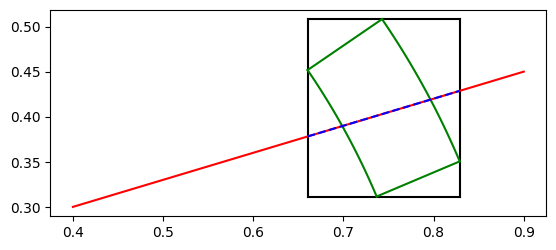

In [7]:

t1 = (le[0] - ray_origin[0])/ray_dir[0]
t2 = (re[0] - ray_origin[0])/ray_dir[0]
tmin = min(t1,t2)
tmax = max(t1,t2)

tmin = max(tmin, min(t1, t2))
tmax = min(tmax, max(t1, t2))

intersects = tmax > tmin

if intersects:
    t_range = np.linspace(tmin, tmax, 25)
    x_intx = ray_origin[0] + t_range * ray_dir[0]
    y_intx = ray_origin[1] + t_range * ray_dir[1]
    
    f, axs = plot_elements()    
    axs.plot(x_intx, y_intx,'--b')

### additional intersections?


in 3d, 3 primitive shapes define the boundaries of a spherical volume element

* ray-sphere for rmin, rmax. 
* ray-plane for the fixed phi at phi0, phi1
* ray-cone for fixed theta at theta1, thetat2 

so that's additional 6 intersection tests, some of which may have multiple intersections (ray-sphere will have 0, 1, or 2, ray-cone can have 0, 1, 2, and 2+imaginary ghost-cone intersection, ray-plane is 0, 1 or infinite). 

So kinda a lot to do... 

modifying the initial glsl implementations i had:

In [8]:
def get_ray_plane_intersection(p_normal, p_constant, ray_origin, ray_dir):
    # intersection with a plane defined by constant phi
    n_dot_u = np.dot(p_normal, ray_dir)
    n_dot_ro = np.dot(p_normal, ray_origin)

    # ray is parallel to plane with infinite or no intersections 
    if (n_dot_u == float(0.0)):
        return False, []    

    # otherwise, the the intersection is at
    t_point = [np.asarray([(p_constant - n_dot_ro) / n_dot_u,]),]
    return True, t_point

In [9]:
def get_ray_sphere_intersection(r, ray_origin, ray_dir):
    # intersection with a sphere defined by constant r
    dir_dot_dir = np.dot(ray_dir, ray_dir)
    ro_dot_ro = np.dot(ray_origin, ray_origin)
    dir_dot_ro = np.dot(ray_dir, ray_origin)
    rsq = r * r

    a_2 = 2.0 * dir_dot_dir
    b = 2.0 * dir_dot_ro
    c =  ro_dot_ro - rsq
    determinate = b*b - 2.0 * a_2 * c
    
    if determinate < 0.0:
        return False, []    
    elif determinate == 0.0:
        t_point = -b / a_2;
        return True, [t_point,]
    else:
        t_point1 = (-b - np.sqrt(determinate))/ a_2
        t_point2 = (-b + np.sqrt(determinate))/ a_2
        return True, [t_point1, t_point2]    
    

In [10]:
def get_ray_cone_intersection(theta, ray_origin, ray_dir):
    # intersection with a cone defined by constant theta
    
    if theta > np.pi/2.0:
        # if theta is past PI/2, the cone will point in negative z and the
        # half angle should be measured from the -z axis, not +z.
        vhat = np.array([0.0, 0.0, -1.0])
        costheta = np.cos(np.pi - theta)  
    else:    
        vhat = np.array([0.0, 0.0, 1.0])
        costheta = np.cos(theta)
    
    cos2t = costheta **2 
    # note: theta = PI/2.0 is well defined. determinate = 0 in that case and
    # the cone becomes a plane in x-y.

    dir_dot_vhat = np.dot(ray_dir, vhat)
    dir_dot_dir = np.dot(ray_dir, ray_dir)
    ro_dot_vhat = np.dot(ray_origin, vhat)
    ro_dot_dir = np.dot(ray_origin, ray_dir)
    ro_dot_ro = np.dot(ray_origin, ray_dir)

    a_2 = 2.0*(np.pow(dir_dot_vhat, 2) - dir_dot_dir * cos2t)
    b = 2.0 * (ro_dot_vhat * dir_dot_vhat - ro_dot_dir*cos2t)
    c = np.pow(ro_dot_vhat, 2) - ro_dot_ro*cos2t
    determinate = b*b - 2.0 * a_2 * c;
    
    if determinate < 0.0:
        # no intersections
        return False, []    
    elif determinate == 0.0:  
        # single intersection
        t_point = -b / a_2
        return True, [t_point,]
    else:    
        # 2 intersections. But note that:
        # note: it is also possible to have real solutions that intersect the shadow cone
        # and not the actual cone. those values will fail the bounds checks for
        # interesecting the volume so no special treatment is needed.
        t_point1 = (-b - sqrt(determinate))/ a_2
        t_point2 = (-b + sqrt(determinate))/ a_2;
        return True, [t_point1, t_point2]

So... let's calculate all those intersections. Remember -- still doing this in 3D here, the plots are just 2Dish enough to make sense.

In [11]:
sphere_int_1 = get_ray_sphere_intersection(r0, ray_origin, ray_dir)
sphere_int_2 = get_ray_sphere_intersection(r1, ray_origin, ray_dir)
sphere_int_1, sphere_int_2

((True, [array([-1.25053603]), array([0.31186627])]),
 (True, [array([-1.35266677]), array([0.41399701])]))

In [12]:
cone_int_1 = get_ray_cone_intersection(theta0, ray_origin, ray_dir)
cone_int_2 = get_ray_cone_intersection(theta1, ray_origin, ray_dir)
cone_int_1, cone_int_2

((False, []), (False, []))

Cone intersections will always be null for this notebook, since rays line in the z = 0 plane.

anyway, Using `get_ray_plane_intersection` will require calculating those phi-normal planes first

In [13]:
import numpy as np


def phi_normal_plane(r, theta, phi):
    # simplified from
    # https://github.com/yt-project/yt_idv/blob/3cef5b304a403cec17bd02ba6d11bb9b934c98db/yt_idv/scene_data/_geometry_utils.py
    # for use with a single plane    

    # get the cartesian values of the coordinates
    z = r * np.cos(theta)
    r_xy = r * np.sin(theta)
    x = r_xy * np.cos(phi)
    y = r_xy * np.sin(phi)
    xyz = np.concatenate([x, y, z])    

    # construct the plane
    z_hat = np.array([0, 0, 1])
    normal_vec = np.cross(xyz, z_hat)    
    d = np.dot(normal_vec, xyz) # find any point in the plane.

    plane = [normal_vec, float(d)]
    return plane 

p0 = phi_normal_plane(r0, theta0, phi0) # r, theta values should not matter
p1 = phi_normal_plane(r0, theta0, phi1) # r, theta values should not matter

In [14]:
plane_1 = get_ray_plane_intersection(p0[0], p0[1], ray_origin, ray_dir)
plane_2 = get_ray_plane_intersection(p1[0], p1[1], ray_origin, ray_dir)
plane_1, plane_2

((True, [array([1.11281034])]), (True, [array([0.07160281])]))

In [15]:
all_t_vals = plane_1[1] + plane_2[1] + cone_int_1[1] + cone_int_2[1] + sphere_int_1[1] + sphere_int_2[1]
all_t_vals = np.concatenate(all_t_vals)
all_t_vals

array([ 1.11281034,  0.07160281, -1.25053603,  0.31186627, -1.35266677,
        0.41399701])

In [16]:
new_t = [t for t in all_t_vals if t > tmin and t<tmax]

### tricky edge cases????

`new_t` will be intersections falling within the bounding box (and will always be >0), but its length may vary:

In [17]:
if len(new_t) == 0:
    # intersects bounding box, but not actual element. 
    # neglecting infinite intersections if ray is on the fixed phi-plane... 
    intersects = False
elif len(new_t) == 1: 
    # intersects exactly once, ray hits the cusp of the outer radius sphere
    # just drop it for now
    intersects = False
elif len(new_t) == 4:
    # the hardest case... ray intersects the inner sphere twice 
    # within the bounding box, and intersects both planes. similar 
    # with cone-cusps... yikes. 
    # lets drop it for now? should instead split the ray steps for
    # sampling, but thats gonna branch the shader in a bad way...
    intersects = False 
elif len(new_t) != 2: 
    raise RuntimeError("should only be 2 at this point") 

if intersects:
    # new_t guaranteed to be positive!
    new_tmin = min(new_t)
    new_tmax = max(new_t)
    
    print(new_tmin, new_tmax)

0.311866265503084 0.41399701107191617


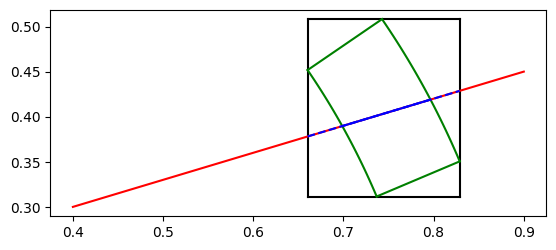

In [18]:
if intersects:
    f, axs = plot_elements()    
    axs.plot(x_intx, y_intx,'--b')
    
    t_range = np.linspace(new_tmin, new_tmax, 25)
    x_intx_n = ray_origin[0] + t_range * ray_dir[0]
    y_intx_n = ray_origin[1] + t_range * ray_dir[1]
    axs.plot(x_intx_n, y_intx_n,'b')

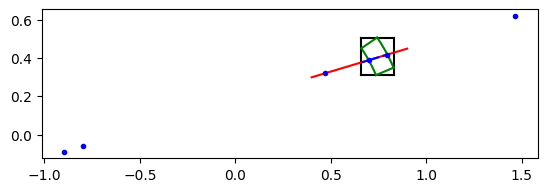

In [20]:
# let's also plot all the t values, just to see where they would fall
if intersects:
    f, axs = plot_elements()    
    axs.plot(x_intx, y_intx,'--b')
    
    for tval in all_t_vals:           
        x_intx_t = ray_origin[0] + tval * ray_dir[0]
        y_intx_t = ray_origin[1] + tval * ray_dir[1]
        axs.plot(x_intx_t, y_intx_t,'.b')
